Fold 1 Test Accuracy: 0.85
Fold 2 Test Accuracy: 0.85
Fold 3 Test Accuracy: 0.85
Fold 4 Test Accuracy: 0.85
Fold 5 Test Accuracy: 0.84
Fold 6 Test Accuracy: 0.85
Fold 7 Test Accuracy: 0.85
Mean Test Accuracy: 0.85


Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) curve')

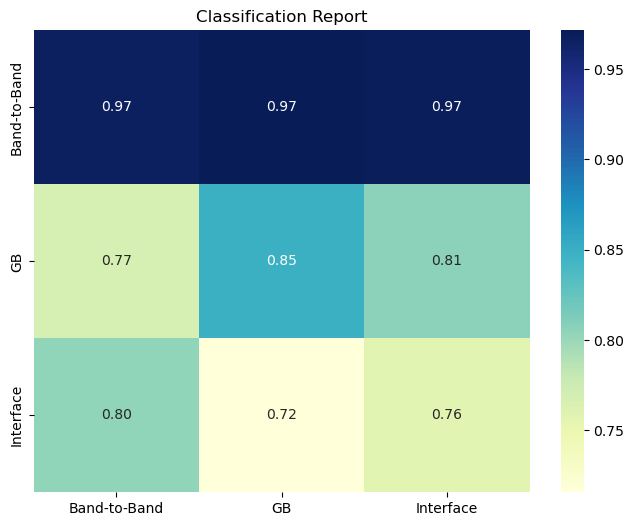

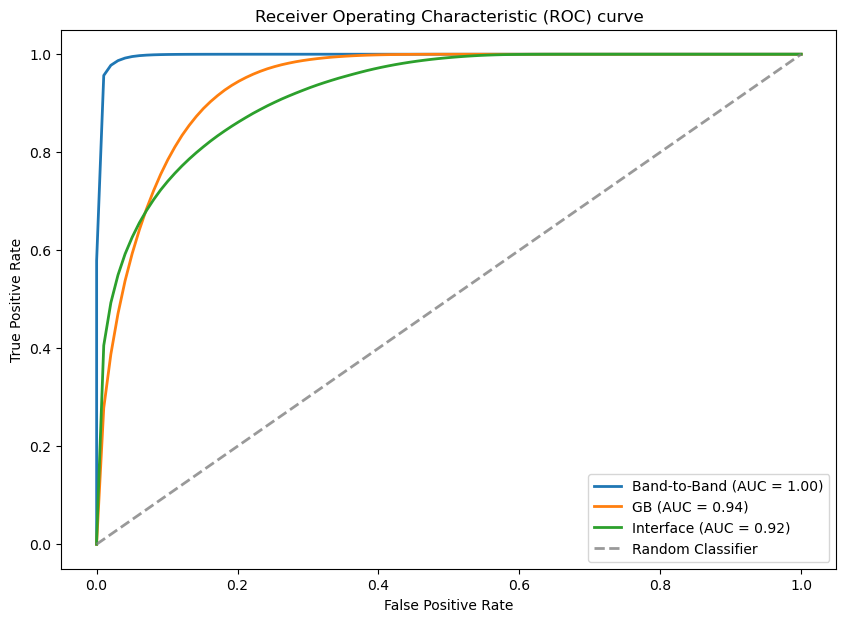

In [2]:
import numpy as np
import pickle
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
import pandas as pd


# Function to load and evaluate a model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return accuracy, report

# Load saved models
models = []
for i in range(1, 8):
    model_name = f"Manual/fold_models/fold_{i}_model.pkl"
    with open(model_name, "rb") as f:
        models.append(pickle.load(f))

# Load test data
y_test = np.load("/home/basir/basir/Prunedoptuna/SAVED_TRAINED&TEST/ind_test_labels.npy")
X_test = np.load("/home/basir/basir/Prunedoptuna/SAVED_TRAINED&TEST/ind_X_test.npy")

# Evaluate each model and calculate mean accuracy
fold_accuracies = []
for i, model in enumerate(models):
    fold_accuracy, _ = evaluate_model(model, X_test, y_test)
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {i+1} Test Accuracy: {fold_accuracy:.2f}")

mean_accuracy = np.mean(fold_accuracies)
mean_accuracy_str = "{:.2f}".format(mean_accuracy)  # Format as a string with 2 decimal places
print("Mean Test Accuracy:", mean_accuracy_str)

# Save mean accuracy to file as a string with 2 decimal places
with open("Manual/Test_mean_accuracy.txt", "w") as f:
    f.write(mean_accuracy_str)

# Plot the classification report as a heatmap for one model (you can modify this for others)
_, report = evaluate_model(models[0], X_test, y_test)
report.pop('micro avg', None)
report.pop('macro avg', None)
report.pop('weighted avg', None)

# Plot the classification report as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :-1].T, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=['Band-to-Band', 'GB', 'Interface'], yticklabels=['Band-to-Band', 'GB', 'Interface'])
plt.title("Classification Report")
plt.savefig('classification_report_heatmap.png', dpi=300)
# Initialize variables to store mean ROC curves for all folds
mean_fpr = np.linspace(0, 1, 100)

# Plot mean ROC curves for each class
plt.figure(figsize=(10, 7))

# Plot ROC curves and calculate mean AUC for each class
for i, class_label in enumerate(['Band-to-Band', 'GB', 'Interface']):
    tprs_class = []
    for j in range(7):
        y_score = models[j].predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, i], pos_label=i)
        tprs_class.append(np.interp(mean_fpr, fpr, tpr))

    mean_tpr = np.mean(tprs_class, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot([0] + mean_fpr.tolist(), [0] + mean_tpr.tolist(), linewidth=2, label=f"{class_label} (AUC = {mean_auc:.2f})")
# Plot random classifier
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=0.8, label='Random Classifier')    
# Add legend and labels
plt.legend(loc='lower right', fontsize=10)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
